# Stochastic Volatility model

In [69]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(\frac{y_i}{y_{i-1}}) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $y$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [60]:
n = 400
returns = np.genfromtxt(pm.get_data("SP500.csv"))
returns[:5]

array([ 0.002081, -0.010736, -0.002669, -0.008246, -0.029663])

As you can see, the volatility seems to change over time quite a bit but cluster around certain time-periods. Around time-points 2500-3000 you can see the 2009 financial crash.

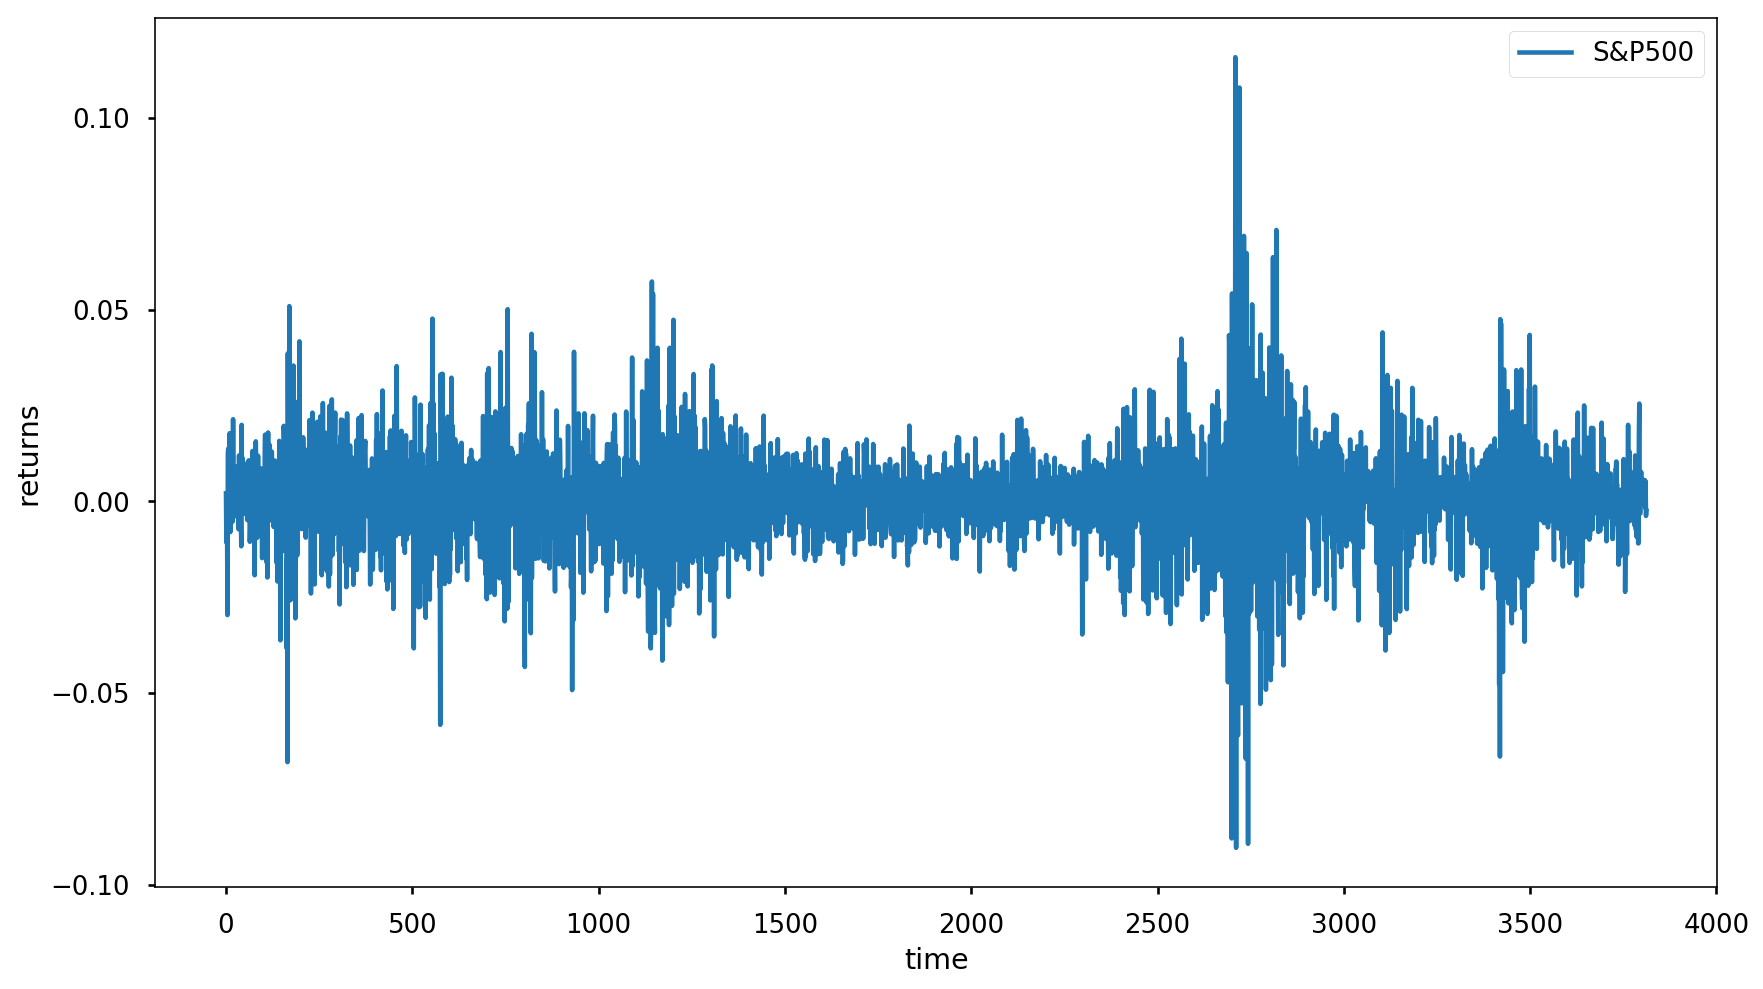

In [72]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns, label='S&P500')
ax.set(xlabel='time', ylabel='returns')
ax.legend();

Specifying the model in `PyMC3` mirrors its statistical specification. 

In [77]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', 50.)

    nu = pm.Exponential('nu', .1)
    s = GaussianRandomWalk('s', sd=sigma, shape=len(returns))

    r = pm.StudentT('r', nu, lam=pm.math.exp(-2*s), observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. NUTS, however, gives the correct posterior.

In [50]:
with model:
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [12:27<00:00,  2.80it/s]


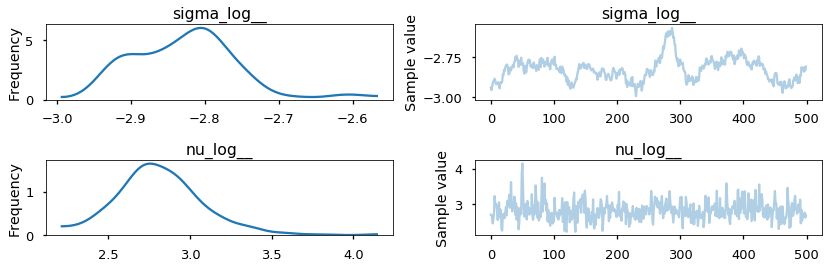

In [66]:
pm.traceplot(trace, model.vars[:-1]);

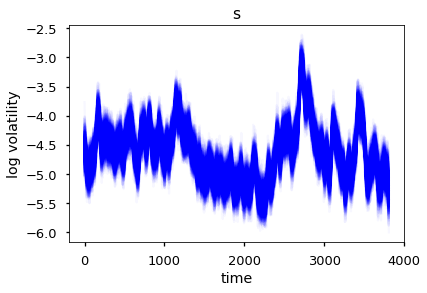

In [67]:
plt.title(str(s))
plt.plot(trace[s].T, 'b', alpha=.03);
plt.xlabel('time')
plt.ylabel('log volatility');

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

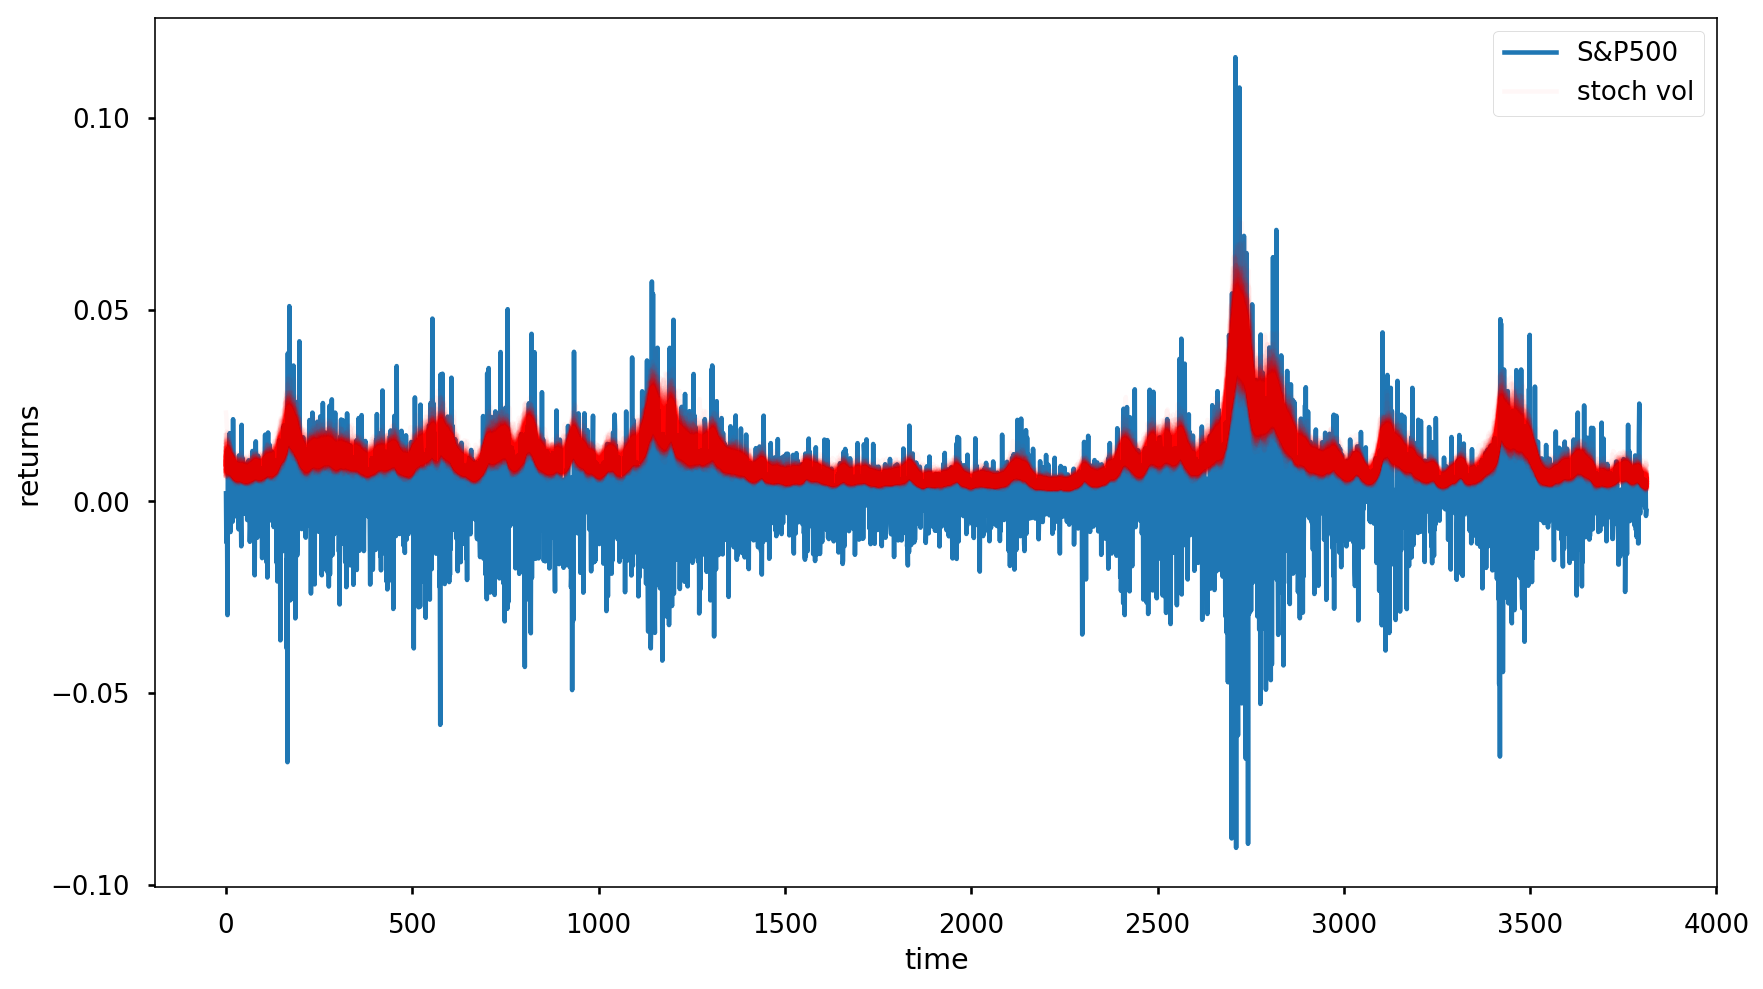

In [73]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns)
ax.plot(np.exp(trace[s].T), 'r', alpha=.03);
ax.set(xlabel='time', ylabel='returns')
ax.legend(['S&P500', 'stoch vol']);

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 